# Long Short Term Memory Model to Predict Weather in New Delhi

This notebook aims to forecast the mean temperature in New Delhi using 4 different features (mean temperature, humidity, wind speed and mean pressure).

A Biderectional Long Short Term Memory model is used for this purpose. The dataset is a time series and the model built in this case uses the previous 30 days of data to forecast the mean temperature of the next day.

In a bidirectional LSTM, we give the input from both right to left and from left to right.

## Importing of Packages

Here, we import the necessary packages such as numpy (for numerical and array calculations), pandas (data-handling) and torch (building of machine learning model).

In [281]:
import numpy as np
import pandas as pd

import torch
import torchvision
import torch.nn as nn   # neural network modules
import torch.optim as optim   # optimization algorithms
import torch.nn.functional as F   # functions without parameters like activation functions
from torch.utils.data import TensorDataset, DataLoader, Dataset   # dataset management, create batches
import torchvision.datasets as datasets   # standard datasets on pytorch
import torchvision.transforms as transforms   #transform datasets

import matplotlib.pyplot as plt

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

## Device

Set device to GPU if available, else, send to CPU. The data and model will be sent to the device.

In [282]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Exploratory Data Analysis

In [283]:
train_dataset = pd.read_csv("DailyDelhiClimateTrain.csv")

print(f"Full train dataset shape is {train_dataset.shape}")

Full train dataset shape is (1462, 5)


In [284]:
train_dataset.head()

date   meantemp   humidity  wind_speed  meanpressure
0  2013-01-01  10.000000  84.500000    0.000000   1015.666667
1  2013-01-02   7.400000  92.000000    2.980000   1017.800000
2  2013-01-03   7.166667  87.000000    4.633333   1018.666667
3  2013-01-04   8.666667  71.333333    1.233333   1017.166667
4  2013-01-05   6.000000  86.833333    3.700000   1016.500000

Examine the data points briefly using a box plot. This helps us to visualise the data and identify outliers at a glance.

<Axes: >

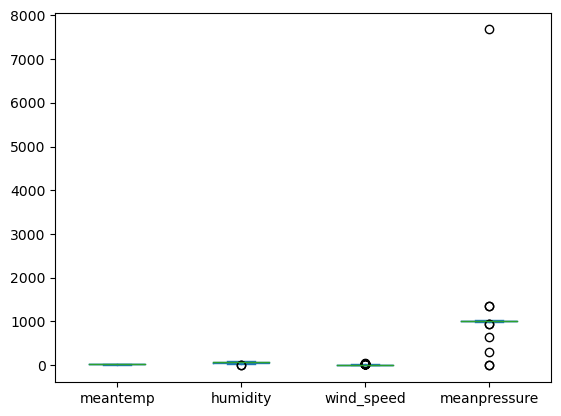

In [285]:
train_dataset.plot(kind='box')

We take a closer look at the data to find outliers and if it is necessary to remove them.

In [286]:
train_dataset.describe()

meantemp     humidity   wind_speed  meanpressure
count  1462.000000  1462.000000  1462.000000   1462.000000
mean     25.495521    60.771702     6.802209   1011.104548
std       7.348103    16.769652     4.561602    180.231668
min       6.000000    13.428571     0.000000     -3.041667
25%      18.857143    50.375000     3.475000   1001.580357
50%      27.714286    62.625000     6.221667   1008.563492
75%      31.305804    72.218750     9.238235   1014.944901
max      38.714286   100.000000    42.220000   7679.333333

We remove outliers using z-score (number of standard deviations by which the value of a raw score is above or below the mean value) and we set the limit to 3. As seen from the table above, this only applies to wind speed and mean pressure.

In [287]:
from scipy import stats

z_windspeed = np.abs(stats.zscore(train_dataset['wind_speed']))
z_meanpressure = np.abs(stats.zscore(train_dataset['meanpressure']))

z_data = [z_windspeed,z_meanpressure]
z_list = []
for x in z_data:
    z_list.extend(np.where(x>3)[0].flatten().tolist())

print(len(z_list))
train_dataset = train_dataset.drop(index = z_list, axis=0)

final_dataset = pd.DataFrame(train_dataset)
print(final_dataset.shape)

18
(1444, 5)


In [288]:
final_dataset['date'] = pd.to_datetime(final_dataset['date'])

final_dataset.head()

date   meantemp   humidity  wind_speed  meanpressure
0 2013-01-01  10.000000  84.500000    0.000000   1015.666667
1 2013-01-02   7.400000  92.000000    2.980000   1017.800000
2 2013-01-03   7.166667  87.000000    4.633333   1018.666667
3 2013-01-04   8.666667  71.333333    1.233333   1017.166667
4 2013-01-05   6.000000  86.833333    3.700000   1016.500000

Create the feature set which is a numpy array containing the data for 4 features and for all rows.

We then choose the mean temperature to be the predicted value.

In [289]:
feature_set = final_dataset.to_numpy()[:,[1,2,3,4]]
out_feature_index = 0 #meantemp
feature_set.shape

(1444, 4)

In [290]:
feature_set

array([[10.0, 84.5, 0.0, 1015.6666666666666],
       [7.4, 92.0, 2.98, 1017.8],
       [7.166666666666667, 87.0, 4.633333333333334, 1018.6666666666666],
       ...,
       [14.095238095238097, 89.66666666666667, 6.266666666666667,
        1017.904761904762],
       [15.052631578947368, 87.0, 7.325, 1016.1],
       [10.0, 100.0, 0.0, 1016.0]], dtype=object)

We scale the data within the range 0 to 1 using MinMaxScaler and create 2 datasets (one containing all the 4 features, one containing only the mean temperatures). For the output set, the reshape function is needed as the scaler expects a 2D array.

Purpose of normalization is so that during gradient descent, the model will be able to converge better to a minimum. If the features had different ranges, their gradients will vary and the rate of change of the cost function with respect to each feature will be different. A unit change for a feature with smaller range will have a smaller impact on the cost function.

In [291]:
from sklearn.preprocessing import MinMaxScaler

cols_to_normalize = ['meantemp', 'humidity', 'wind_speed', 'meanpressure']
ycol = ['meantemp']

scaler = MinMaxScaler()

scaled_data = scaler.fit_transform(feature_set)
yscaled_data = scaler.fit_transform(feature_set[:,out_feature_index].reshape(-1,1))
# scaler expects 2d --> needs reshape
# The -1 in the first dimension indicates that the resulting array should have a size that is automatically determined to ensure that all the elements are included.
# The 1 in the second dimension indicates that the resulting array should have a single column.
# The purpose of this reshaping is to convert a 1-dimensional array (shape (n,)) into a 2-dimensional array with a single column (shape (n, 1)).

print(scaled_data.shape)
print(yscaled_data.shape)

(1444, 4)
(1444, 1)


## Setting of Hyperparameters

Input size represents the number of features.

Sequence length (x) refers to of x days worth of data prior to the present value.

We use 2 layers of LSTM of size 256 nodes. Learning rate is set to 0.001. Batch size is set to 16.

The number of epochs (20) defines the number times that the learning algorithm will work through the entire training dataset

In [292]:
# hyperparameters

input_size = 4   # num_features
sequence_length = 30   #blocksize

num_layers = 2
hidden_size = 256
learning_rate = 0.001
batch_size = 16
num_epochs = 20

We separate the data into training data and validation data with a 80:20 split.

In [293]:
x_train_data,y_train_data=[],[]
x_val_data,y_val_data=[],[]

for i in range(sequence_length, len(scaled_data)):
    if i < int(1444*0.8):
        x_train_data.append(scaled_data[i - sequence_length : i,  :])
        y_train_data.append(yscaled_data[i])
        
    else:
        x_val_data.append(scaled_data[i - sequence_length : i,  :])
        y_val_data.append(yscaled_data[i])        
    
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)
x_val_data,y_val_data=np.array(x_val_data),np.array(y_val_data)

print(x_train_data.shape)
print(y_train_data.shape)
print(x_val_data.shape)
print(y_val_data.shape)


(1125, 30, 4)
(1125, 1)
(289, 30, 4)
(289, 1)


## Creating the LSTM Model

First, we inherit the nn.Module within PyTorch which is a class created for general neural networks to create the LSTM class.

Then, the initialisation method is created.

super calls the initialization method of parents class nn.Module. It takes in two parameters: the first is the subclass, and the second parameter is an object that is an instance of that subclass

The LSTM layers are created:
batch_first --> If True, then the input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature)
bidirectional --> If True, becomes a bidirectional LSTM

A final fully connected layer is created. The hidden size needs to be multiplied by 2 because one layer going forward and the other going backward.

Last, we define the forward pass method.

We need to define the hidden state and cell state for each node to be sent to the LSTM which we instantiate as a 3D zero tensor.

The number of layers need to be multiplied by 2 because one layer going forward and the other going backward but they are all concatenated for the same hidden state. x.size(0) is the number of examples in a batch size. 

We take the last output hidden layer of the LSTM and send it to the linear layer.

In [294]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True, bidirectional = True)
        self.fc = nn.Linear(hidden_size * 2, 1)
        
    def forward(self, x):

        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        
        out, (hidden_state, cell_state) = self.lstm(x, (h0, c0))   # only output is used here
        out = self.fc(out[:, -1, :])
        
        return out

The model is sent to the device.

In [295]:
model = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers).to(device)

## Criterion and Optimizer

The MSELoss loss criterion is used as this is a regression problem where the output is a continuous value and we can use mean-squared-error to calculate the loss function. The model will aim to minimize the average squared distance between predicted and true values and penalizes larger errors more heavily than smaller errors due to the squaring operation.

Adam (Adaptive Moment Estimation) optimizer adapts the learning rate for each parameter based on its gradients and past updates. It computes separate learning rates for different parameters, allowing the optimizer to adjust the learning rates dynamically during training. This helps with faster convergence during back propagation.

parameters() function was from inhertied nn.Module class
When a Parameter is associated with a module as a model attribute, it gets added to the parameter list automatically and can be accessed using the 'parameters' iterator. They are the weights and biases of the model for each layer and their connections.

In [296]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  

Convert the numpy arrays of data into tensors and load them into DataLoader to create batches.

shuffle=False is used as we do not want to disrupt the temporal element of the data.

In [297]:
train_x = torch.tensor(x_train_data, dtype=torch.float32)
train_y = torch.tensor(y_train_data, dtype=torch.float32)
val_x = torch.tensor(x_val_data, dtype=torch.float32)
val_y = torch.tensor(y_val_data, dtype=torch.float32)

train_dataset = TensorDataset(train_x, train_y)
val_dataset = TensorDataset(val_x, val_y)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

## Define the function for training per epoch

We use enumerate(training_loader) instead of iter(training_loader) so that we can track the batch index and do some intra-epoch reporting. Each data instance is an input + label pair.

We need to zero the gradients for every batch to prevent gradient accumulation across different batches (only want to aggregate within a batch).

outputs = model(batch_x) --> predictions are made for the batch 

loss = criterion(outputs.squeeze(), batch_y) --> loss is calculated

loss.backward() --> computes the partial derivative of the output f with respect to each of the input variables.

optimizer.step() --> adam step and updates the parameters

Next, we retrieve the scalar cvalue of the loss function for the current batch and print out the loss every 10 batches.

tb_x = epoch_index * len(train_loader) + index + 1: This line calculates the value for the x-axis of a scalar summary in TensorBoard. It combines the current epoch index (epoch_index), the total number of batches per epoch (len(train_loader)), and the current batch index (index + 1) to get a unique value that represents the progress of training.

tb_writer.add_scalar('Loss/train', last_loss, tb_x): This line adds a scalar summary to a TensorBoard writer (tb_writer is an instance of SummaryWriter). It logs the training loss (last_loss) under the tag 'Loss/train' at the x-axis value specified by tb_x

Finally, the running loss is reset for the next set of 10 batches

In [298]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    for index, data in enumerate(train_loader):

        batch_x, batch_y = data

        optimizer.zero_grad()

        outputs = model(batch_x)

        loss = criterion(outputs.squeeze(), batch_y)
        loss.backward()

        optimizer.step()


        running_loss += loss.item() 
        if index % 10 == 9: 
            last_loss = running_loss / 10 # loss per batch
            print(f'  batch {index + 1} loss: {last_loss}')
            tb_x = epoch_index * len(train_loader) + index + 1 
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0

    return last_loss #last calculated batch loss

## Returning the Results

First, the SummaryWriter is instantiated.

We set model to training mode to make sure that:
1. batch normalization or dropout layers are in effect
2. enables autograd tracking, which means that the model keeps track of the operations performed during the forward pass to calculate gradients during backpropagation. This allows the model to update its parameters based on the computed gradients.

We use the training function to run for one epoch.

The model is set back to evaluation mode as gradients are unnecessary for reporting of results on validation set.

We then repeat the process of calculating the error and reporting it once for one epoch and also the average loss for the training set.

We can log the results into Tensorboard and also save the model's state when it produces a new best performance.


In [299]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter(f'runs/Delhi_temp_trainer_{timestamp}')
epoch_number = 0

best_vloss = 1_000_000.

for epoch in range(num_epochs):
    print(f'EPOCH {epoch_number + 1}:')

    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer) 

    model.eval()

    running_vloss = 0.0
    for index, vdata in enumerate(val_loader):
        vbatch_x, vbatch_y = vdata
        voutputs = model(vbatch_x)
        vloss = criterion(voutputs.squeeze(), vbatch_y)
        running_vloss += vloss

    avg_vloss = running_vloss / (index + 1)
    print(f'LOSS: train {avg_loss} validation {avg_vloss}')
    
    '''
    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = f'model_{timestamp}_{epoch_number}'
        torch.save(model.state_dict(), model_path)
    '''
    epoch_number += 1

EPOCH 1:


/Users/pirey/miniconda3/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


  batch 10 loss: 0.06505422201007605
  batch 20 loss: 0.039954711124300955
  batch 30 loss: 0.1174403615295887
  batch 40 loss: 0.14612041059881448
  batch 50 loss: 0.10406408119015395
  batch 60 loss: 0.11511027179658413
  batch 70 loss: 0.0659427233505994


/Users/pirey/miniconda3/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/pirey/miniconda3/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


LOSS: train 0.0659427233505994 validation 0.038318932056427
EPOCH 2:
  batch 10 loss: 0.06025623129680753
  batch 20 loss: 0.03869416220113635
  batch 30 loss: 0.04256501779891551
  batch 40 loss: 0.03423872496932745
  batch 50 loss: 0.019244837295264005
  batch 60 loss: 0.02632399518042803
  batch 70 loss: 0.009874309680890292
LOSS: train 0.009874309680890292 validation 0.015189691446721554
EPOCH 3:
  batch 10 loss: 0.010655763489194215
  batch 20 loss: 0.012897711526602507
  batch 30 loss: 0.02131158858537674
  batch 40 loss: 0.01826212229207158
  batch 50 loss: 0.01950896279886365
  batch 60 loss: 0.0140685913618654
  batch 70 loss: 0.006801265082322061
LOSS: train 0.006801265082322061 validation 0.015825098380446434
EPOCH 4:
  batch 10 loss: 0.009535149671137333
  batch 20 loss: 0.011040335847064852
  batch 30 loss: 0.01451568838674575
  batch 40 loss: 0.022474946500733495
  batch 50 loss: 0.016125468839891254
  batch 60 loss: 0.03816885445266962
  batch 70 loss: 0.0129866544040851

As we can see from the results above, the loss decreases as the model gets trained over more epochs.

## Checking the MSE of Model

As this is for evaluation, it is not necessary to optimise with gradients as this will waste time and thus we use torch.no_grad()

Here, we need to unscale the data to calculate the actual MSE of the results and thus we use the inverse_transform function of the scaler.

'loss' contains the sum of MSE values of all the outputs within the batch

Sum the loss over all the batches and devide by the number of samples.

The overall MSE is reported.

In [300]:
def check_mse(loader,model): 
    if loader == train_loader: 
        print("checking mse on training data")
    else:
        print("checking mse on test data")
    overall_loss = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad(): 
        for x,y in loader:
            x= x.to(device=device)
            y= y.to(device=device)
            
            outputs = model(x)
            unscaled_outputs = scaler.inverse_transform(np.array(outputs))
            unscaled_y = scaler.inverse_transform(np.array(y))
            
            unscaled_outputs = torch.from_numpy(unscaled_outputs)
            unscaled_y = torch.from_numpy(unscaled_y)            
            
            loss = F.mse_loss(unscaled_outputs,unscaled_y,reduction='sum')
            
            overall_loss += loss.item()
            num_samples += x.size(0)

        mse = overall_loss / num_samples
        print(f"MSE: {mse:.4f}")
        
    model.train()

In [302]:
check_mse(train_loader,model)
check_mse(val_loader,model)

checking mse on training data
MSE: 4.5990
checking mse on test data
MSE: 4.9128


The mean squared error is relatively low for the bi-directional LSTM model, showing that it works for this time series problem.